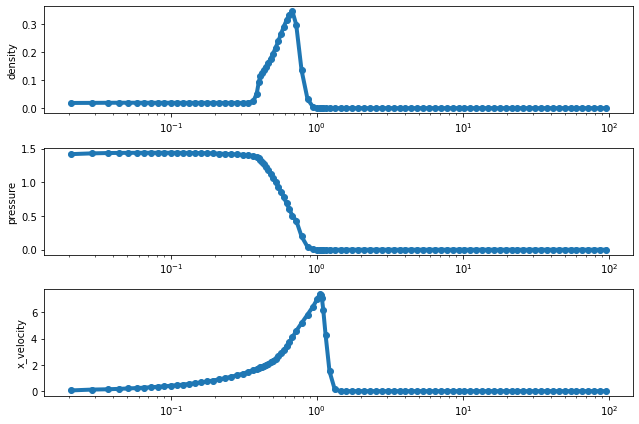

In [1]:
import numpy as np
import h5py
import pylab
import matplotlib.pyplot as plt

pylab.figure(figsize=(9,6))
with h5py.File('output/final.h5', 'r') as f:
    for n, field in enumerate(['density', 'pressure', 'x_velocity']):
        pylab.subplot(3,1,n+1)
        pylab.semilogx(np.array(f['grid']),
                       np.array(f[field]), "o-",
                       linewidth=4)
        pylab.ylabel(field)
        
pylab.tight_layout()
pylab.show()


In [2]:
from scipy.signal import find_peaks 
from scipy.optimize import curve_fit

def parabola(x, a, h, k):
    return a*(x-h)**2+k

# shock trajectory
def get_shock_traj(N):
    # N = number of snapshots
    shock_front = np.zeros(N)
    time = np.zeros(N)
    for i in range(N):
        with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
            P = np.array(f['pressure'])
            rho = np.array(f['density'])
            x_vel = np.array(f['x_velocity'])
            r = np.array(f['grid'])
            peak = find_peaks(x_vel)[0][-1] # the index of the peak
            para_x = r[peak-3:peak+3] # fit a parabola around the peak
            para_y = x_vel[peak-3:peak+3]
            try:
                fit_params, pcov = curve_fit(parabola, para_x, para_y, p0=[-50, r[peak], x_vel[peak]])
                xs = np.linspace(min(para_x), max(para_x), 50)
                shock_front[i] = fit_params[1]
            except RuntimeError:    
                shock_front[i] = r[find_peaks(x_vel)[0][-1]]
            time[i] = np.array(f['time'])[0]
    return time, shock_front

time, shock_front = get_shock_traj(100)


In [3]:
def trajectory(t, a, b):
    return a*t**b
cut = 5
traj_params, traj_pcov = curve_fit(trajectory, time[cut:], shock_front[cut:], p0=[1., 0.4])
print(traj_params)

[1.5734237  0.40059987]


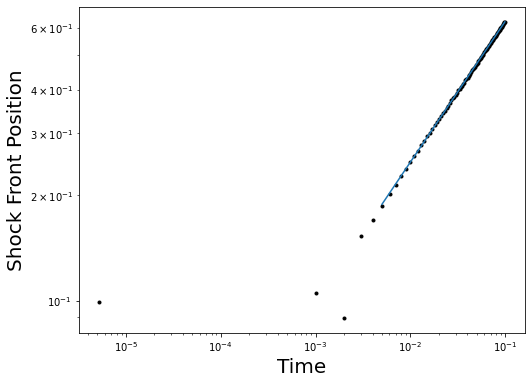

In [4]:
# plot the trajectory
ts = np.linspace(min(time[cut:]), max(time), 100)
plt.figure(figsize=(8,6))
plt.plot(time, shock_front, 'k.')
plt.plot(ts, trajectory(ts, traj_params[0], traj_params[1]))
plt.xlabel('Time', fontsize=20)
plt.ylabel('Shock Front Position', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.savefig('Shock_Trajectory.pdf')
plt.show()

<IPython.core.display.Javascript object>


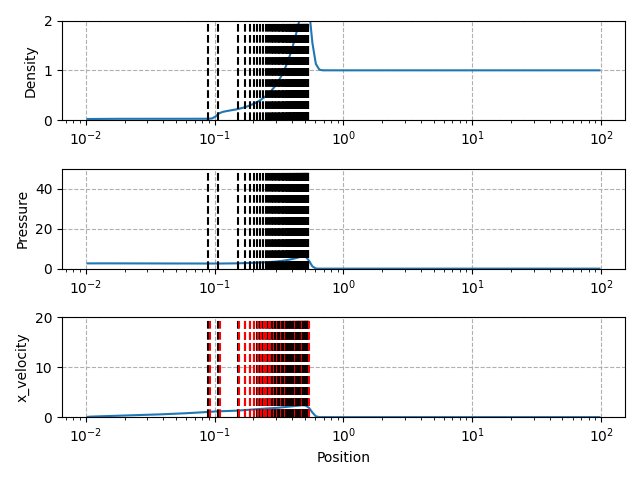

In [ ]:
# animate the shock front
%matplotlib notebook

N = 100 # number of snapshots
shock_front2 = np.zeros(N)
time = np.zeros(N)

with h5py.File('output/snapshot_0.h5', 'r') as f:
    P = np.array(f['pressure'])
    rho = np.array(f['density'])
    x_vel = np.array(f['x_velocity'])
    r = np.array(f['grid'])

# initialize
plt.ion()
fig, ax = plt.subplots(3, 1)
x1, = ax[0].plot(r, rho)
x2, = ax[1].plot(r, P)
x3, = ax[2].plot(r, x_vel)
#x4, = ax[3].plot(shock_front, time, 'ko')

ax[0].set_ylabel('Density')
ax[0].set_ylim([0,2])
ax[0].set_xscale('log')
ax[0].grid(ls='--')

ax[1].set_ylabel('Pressure')
ax[1].set_ylim([0,50])
ax[1].set_xscale('log')
ax[1].grid(ls='--')

ax[2].set_ylabel('x_velocity')
ax[2].set_xlabel('Position')
ax[2].set_ylim([0,20])
ax[2].set_xscale('log')
ax[2].grid(ls='--')

# ax[3].set_ylabel('time')
# ax[3].set_xlabel('Shock Front')
# ax[3].set_ylim([0,0.1])
# ax[3].set_xlim([0.01, 100])
# ax[3].set_xscale('log')
# ax[3].grid(ls='--')

fig.canvas.draw()

# update
for i in range(1,N):
    with h5py.File('output/snapshot_%i.h5' % i, 'r') as f:
        P = np.array(f['pressure'])
        rho = np.array(f['density'])
        x_vel = np.array(f['x_velocity'])
        r = np.array(f['grid'])
        shock_front2[i] = r[find_peaks(x_vel)[0][-1]]
    x1.set_ydata(rho)
    ax[0].axvline(shock_front[i], color='black', linestyle='--')
    x2.set_ydata(P)
    ax[1].axvline(shock_front[i], color='black', linestyle='--')
    x3.set_ydata(x_vel)
    ax[2].axvline(shock_front[i], color='black', linestyle='--')
    #ax[2].axvline(shock_front2[i], color='red', linestyle='--')
#    x4.set_ydata(shock_front)
    fig.canvas.draw()
    plt.tight_layout()
    plt.pause(0.001)
